In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

train_data = pd.read_csv('/home/jupyter/datasphere/project/train_dataset_without132.csv')
validation_data = pd.read_csv('/home/jupyter/datasphere/project/test_dataset_without132.csv')

train_data['sentence'].fillna('', inplace=True)
validation_data['sentence'].fillna('', inplace=True)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['author_id'])
validation_labels = label_encoder.transform(validation_data['author_id'])

tokenizer = RobertaTokenizer.from_pretrained("wantuta/roberta_ancient_greek_mlm")

def tokenize_data(data, tokenizer):
    return tokenizer(data.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_data(train_data['sentence'], tokenizer)
validation_encodings = tokenize_data(validation_data['sentence'], tokenizer)

class GreekTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GreekTextDataset(train_encodings, train_labels)
validation_dataset = GreekTextDataset(validation_encodings, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)




/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

model = RobertaForSequenceClassification.from_pretrained("wantuta/roberta_ancient_greek_mlm", num_labels=len(label_encoder.classes_))


2024-05-08 11:36:47.866910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at wantuta/roberta_ancient_greek_mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [4]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results_menan2',
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="epoch",
    learning_rate=2e-5,
    adam_epsilon=1e-8,
    evaluation_strategy="no",
    lr_scheduler_type='linear'
)



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer.train()

model.save_pretrained("./roberta_attempt_menan2")

import joblib
joblib.dump(label_encoder, "./roberta_attempt_menan2/label_encoder.pkl")

tokenizer.save_pretrained("./roberta_attempt_menan2")



 10%|█         | 564/5640 [06:28<52:34,  1.61it/s]  

{'loss': 2.0733, 'grad_norm': 13.418465614318848, 'learning_rate': 1.9750972762645916e-05, 'epoch': 1.0}


 20%|██        | 1128/5640 [12:59<46:55,  1.60it/s]

{'loss': 1.2739, 'grad_norm': 29.82314682006836, 'learning_rate': 1.7556420233463038e-05, 'epoch': 2.0}


 30%|███       | 1692/5640 [19:30<40:55,  1.61it/s]

{'loss': 0.8115, 'grad_norm': 28.8740291595459, 'learning_rate': 1.536186770428016e-05, 'epoch': 3.0}


 40%|████      | 2256/5640 [26:01<34:56,  1.61it/s]

{'loss': 0.5333, 'grad_norm': 9.257452011108398, 'learning_rate': 1.3167315175097276e-05, 'epoch': 4.0}


 50%|█████     | 2820/5640 [32:31<28:58,  1.62it/s]

{'loss': 0.3659, 'grad_norm': 45.5954475402832, 'learning_rate': 1.0972762645914398e-05, 'epoch': 5.0}


 60%|██████    | 3384/5640 [39:02<23:18,  1.61it/s]

{'loss': 0.2653, 'grad_norm': 14.358227729797363, 'learning_rate': 8.778210116731519e-06, 'epoch': 6.0}


 70%|███████   | 3948/5640 [45:33<17:27,  1.61it/s]

{'loss': 0.2015, 'grad_norm': 0.2668917775154114, 'learning_rate': 6.583657587548638e-06, 'epoch': 7.0}


 80%|████████  | 4512/5640 [52:04<11:41,  1.61it/s]

{'loss': 0.1804, 'grad_norm': 0.0899043008685112, 'learning_rate': 4.389105058365759e-06, 'epoch': 8.0}


 90%|█████████ | 5076/5640 [58:35<05:50,  1.61it/s]

{'loss': 0.1682, 'grad_norm': 0.29010331630706787, 'learning_rate': 2.1945525291828797e-06, 'epoch': 9.0}


 99%|█████████▉| 5586/5640 [1:04:28<00:37,  1.45it/s]

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

test_df_path = 'testing_data_updated.csv'
test_df = pd.read_csv(test_df_path)

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

test_df_path = 'testing_data_updated.csv'
test_df = pd.read_csv(test_df_path)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [16]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained("wantuta/roberta_classifier_ancient2")
model = RobertaForSequenceClassification.from_pretrained("wantuta/roberta_classifier_ancient2")

In [17]:
def tokenize_and_prepare_data(df, tokenizer, label_encoder, max_length=512):
    input_ids = []
    attention_masks = []
    labels = []
    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['sentence'],
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_encoder.transform([row['author_id']])[0])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels


In [18]:
test_df = test_df.dropna(subset=['sentence'])

In [19]:
from torch.utils.data import DataLoader, TensorDataset
import torch

test_input_ids, test_attention_masks, test_labels = tokenize_and_prepare_data(test_df, tokenizer, label_encoder)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 16 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()  
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)  
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy() 
    label_ids = b_labels.to('cpu').numpy()  
    
    predictions.append(logits)
    true_labels.append(label_ids)

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

predicted_labels_numeric = np.argmax(predictions, axis=1)



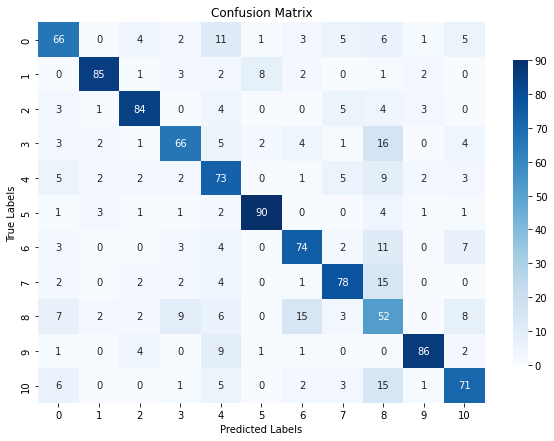

Полнота (Recall): 0.7211538461538461
F1-мера: 0.7263216070553766
Точность на тестовом наборе данных: 0.7211538461538461


In [8]:

cm = confusion_matrix(true_labels, predicted_labels_numeric)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={"shrink": 0.8})
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

predicted_labels_text = label_encoder.inverse_transform(predicted_labels_numeric)

accuracy = accuracy_score(label_encoder.inverse_transform(true_labels), predicted_labels_text)
recall = recall_score(label_encoder.inverse_transform(true_labels), predicted_labels_text, average='macro')
f1 = f1_score(label_encoder.inverse_transform(true_labels), predicted_labels_text, average='macro')

print("Полнота (Recall):", recall)
print("F1-мера:", f1)
print("Точность", accuracy)